# Project_Notes_011

## Forecasting Renewable Energy Generation
In this project, a data with 131008 rows and 12 columns will be used to predict delivery time in hours for the delivery of renewable energy. The data will be visualised using histogram, heat map and boxplot for numerical columns, while the object columns will utilise bar plots and the duplicates, missing values and outliners will be treated with appropriate methods. The first model will be formulated with ensembling while xgboost will be used to compare the result obtained.

### Data Understanding

In [1]:
# Import required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gzip
from datetime import date
from datetime import time
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.model_selection import (
                                        train_test_split, 
                                        RandomizedSearchCV, 
                                        GridSearchCV
                                    )
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
                                RandomForestRegressor, 
                                GradientBoostingRegressor,
                                VotingRegressor, 
                                StackingRegressor
                            )
from sklearn.linear_model import (
                                    LinearRegression, 
                                    Lasso, 
                                    Ridge, 
                                    ElasticNet
                                )
from xgboost import XGBRegressor

In [2]:
# load the data.
df = pd.read_csv('./data/Project_Notes_011_renewable_data.csv')

In [3]:
# Check the shape of data.
df.shape

(131008, 12)

In [4]:
# Check the info of data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131008 entries, 0 to 131007
Data columns (total 12 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Delivery_ID                            131005 non-null  float64
 1   Delivery_Start_Date                    131007 non-null  object 
 2   Delivery_Start_Time                    131007 non-null  object 
 3   Traffic_Conditions                     131008 non-null  object 
 4   Number_of_Packages                     131006 non-null  float64
 5   Customer_Preference_for_Delivery_Time  131008 non-null  object 
 6   Distance_(miles)                       131007 non-null  float64
 7   fog                                    52244 non-null   object 
 8   rain                                   52269 non-null   object 
 9   snow                                   39180 non-null   object 
 10  hail                                   26231 non-null   

In [5]:
# Show a few rows of df.
df.head()

,Delivery_ID,Delivery_Start_Date,Delivery_Start_Time,Traffic_Conditions,Number_of_Packages,Customer_Preference_for_Delivery_Time,Distance_(miles),fog,rain,snow,hail,Historical_Delivery_Time_(hours)
0,1.0,2020-09-03,12:41:00,Low,7.0,Evening,167.884751,NaN,NaN,Low,NaN,9.294688
1,2.0,2022-12-22,20:14:00,Low,10.0,Morning,154.154474,Low,NaN,Mid,NaN,9.303765
2,3.0,2021-06-05,11:20:00,High,2.0,Afternoon,196.084835,NaN,Mid,NaN,NaN,8.734668
3,4.0,2023-05-02,05:50:00,High,15.0,Morning,94.010339,NaN,NaN,NaN,NaN,7.806979
4,5.0,2020-07-07,02:34:00,Moderate,17.0,Evening,202.254271,Mid,NaN,NaN,NaN,12.770403


In [6]:
# Define a dictionary to rename some columns.
col_dict = {
    'Delivery_ID': 'id', 
    'Delivery_Start_Date': 'date', 
    'Delivery_Start_Time': 'time', 
    'Traffic_Conditions': 'traffic', 
    'Number_of_Packages': 'packages',  
    'Customer_Preference_for_Delivery_Time': 'preference', 
    'Distance_(miles)': 'distance', 
    'Historical_Delivery_Time_(hours)': 'delivery'
}

In [7]:
# Rename the required columns.
df = df.rename(columns=col_dict)

In [8]:
# Show a few rows of df.
df.head()

,id,date,time,traffic,packages,preference,distance,fog,rain,snow,hail,delivery
0,1.0,2020-09-03,12:41:00,Low,7.0,Evening,167.884751,NaN,NaN,Low,NaN,9.294688
1,2.0,2022-12-22,20:14:00,Low,10.0,Morning,154.154474,Low,NaN,Mid,NaN,9.303765
2,3.0,2021-06-05,11:20:00,High,2.0,Afternoon,196.084835,NaN,Mid,NaN,NaN,8.734668
3,4.0,2023-05-02,05:50:00,High,15.0,Morning,94.010339,NaN,NaN,NaN,NaN,7.806979
4,5.0,2020-07-07,02:34:00,Moderate,17.0,Evening,202.254271,Mid,NaN,NaN,NaN,12.770403


### Data Cleaning

#### Duplicates

In [9]:
# Check for duplicates.
df.duplicated().sum()

8

In [10]:
# Remove duplicates.
df.drop_duplicates(inplace=True)

In [11]:
# Show the shape of df.
df.shape

(131000, 12)

#### Missing Values

In [12]:
# Check for missing values.
df.isna().sum()

id                 3
date               1
time               1
traffic            0
packages           2
preference         0
distance           1
fog            78762
rain           78735
snow           91820
hail          104771
delivery           1
dtype: int64

In [13]:
# Drop the id column.
df.drop('id', axis=1, inplace=True)

In [14]:
# Show the shape of df.
df.shape

(131000, 11)

In [15]:
# Create function to calculate percentage missing values.
def miss_percent(df):
    miss_val = df.isna().sum()
    miss_ind = miss_val.index.to_list()
    
    for x in range(len(miss_val)):
        print(f'Percentage missing in {miss_ind[x]} is: {int(miss_val.iloc[x] / 131000 * 100)}%')

In [16]:
# Calculate the percentage of missing values in each column.
miss_percent(df)

Percentage missing in date is: 0%
Percentage missing in time is: 0%
Percentage missing in traffic is: 0%
Percentage missing in packages is: 0%
Percentage missing in preference is: 0%
Percentage missing in distance is: 0%
Percentage missing in fog is: 60%
Percentage missing in rain is: 60%
Percentage missing in snow is: 70%
Percentage missing in hail is: 79%
Percentage missing in delivery is: 0%


The 'id', 'fog', 'rain', 'snow' and 'hail' columns have substantial missing values which will be replaced by 'unknown'.

In [17]:
# Replace nan in the columns.
miss_col = ['fog', 'rain', 'snow', 'hail']
miss_mask = {np.nan: 'Unknown'}

for col in miss_col:
    df.replace({col: miss_mask}, inplace=True)

In [18]:
# Show a few rows of df.
df.head()

,date,time,traffic,packages,preference,distance,fog,rain,snow,hail,delivery
0,2020-09-03,12:41:00,Low,7.0,Evening,167.884751,Unknown,Unknown,Low,Unknown,9.294688
1,2022-12-22,20:14:00,Low,10.0,Morning,154.154474,Low,Unknown,Mid,Unknown,9.303765
2,2021-06-05,11:20:00,High,2.0,Afternoon,196.084835,Unknown,Mid,Unknown,Unknown,8.734668
3,2023-05-02,05:50:00,High,15.0,Morning,94.010339,Unknown,Unknown,Unknown,Unknown,7.806979
4,2020-07-07,02:34:00,Moderate,17.0,Evening,202.254271,Mid,Unknown,Unknown,Unknown,12.770403


In [19]:
# Drop other missing values.
df.dropna(inplace=True)

In [20]:
# Check for mising values.
df.isna().sum()

date          0
time          0
traffic       0
packages      0
preference    0
distance      0
fog           0
rain          0
snow          0
hail          0
delivery      0
dtype: int64

In [21]:
# Check the shape of df.
df.shape

(130994, 11)

### Feature Engineering

In [22]:
# Split the date column into year, month and day columns.
df['year'] = [int(pd.to_datetime(x).year) for x in df['date']]
df['month'] = [int(pd.to_datetime(x).month) for x in df['date']]
df['day'] = [int(pd.to_datetime(x).day) for x in df['date']]

In [23]:
# Split the time column into hour, minute and second columns.
df['hour'] = [int(pd.to_datetime(x).hour) for x in df['time']]
df['minute'] = [int(pd.to_datetime(x).minute) for x in df['time']]
df['second'] = [int(pd.to_datetime(x).second) for x in df['time']]

In [24]:
# Show a few rows of df.
df.head()

,date,time,traffic,packages,preference,distance,fog,rain,snow,hail,delivery,year,month,day,hour,minute,second
0,2020-09-03,12:41:00,Low,7.0,Evening,167.884751,Unknown,Unknown,Low,Unknown,9.294688,2020,9,3,12,41,0
1,2022-12-22,20:14:00,Low,10.0,Morning,154.154474,Low,Unknown,Mid,Unknown,9.303765,2022,12,22,20,14,0
2,2021-06-05,11:20:00,High,2.0,Afternoon,196.084835,Unknown,Mid,Unknown,Unknown,8.734668,2021,6,5,11,20,0
3,2023-05-02,05:50:00,High,15.0,Morning,94.010339,Unknown,Unknown,Unknown,Unknown,7.806979,2023,5,2,5,50,0
4,2020-07-07,02:34:00,Moderate,17.0,Evening,202.254271,Mid,Unknown,Unknown,Unknown,12.770403,2020,7,7,2,34,0


In [25]:
# Sum the second column.
df['second'].sum()

0

In [26]:
# Drop the date, time and time columns after spliting.
df.drop(columns=['date', 'time', 'second'], axis=1, inplace=True)

In [27]:
# Show a few rows of df.
df.head()

,traffic,packages,preference,distance,fog,rain,snow,hail,delivery,year,month,day,hour,minute
0,Low,7.0,Evening,167.884751,Unknown,Unknown,Low,Unknown,9.294688,2020,9,3,12,41
1,Low,10.0,Morning,154.154474,Low,Unknown,Mid,Unknown,9.303765,2022,12,22,20,14
2,High,2.0,Afternoon,196.084835,Unknown,Mid,Unknown,Unknown,8.734668,2021,6,5,11,20
3,High,15.0,Morning,94.010339,Unknown,Unknown,Unknown,Unknown,7.806979,2023,5,2,5,50
4,Moderate,17.0,Evening,202.254271,Mid,Unknown,Unknown,Unknown,12.770403,2020,7,7,2,34


In [28]:
# Rearrange df.
df = df[['traffic', 'packages', 'preference', 'distance', 'fog', 'rain', 
         'snow', 'hail', 'year', 'month', 'day', 'hour', 'minute', 'delivery']]

In [29]:
# Show a few rows of df.
df.head()

,traffic,packages,preference,distance,fog,rain,snow,hail,year,month,day,hour,minute,delivery
0,Low,7.0,Evening,167.884751,Unknown,Unknown,Low,Unknown,2020,9,3,12,41,9.294688
1,Low,10.0,Morning,154.154474,Low,Unknown,Mid,Unknown,2022,12,22,20,14,9.303765
2,High,2.0,Afternoon,196.084835,Unknown,Mid,Unknown,Unknown,2021,6,5,11,20,8.734668
3,High,15.0,Morning,94.010339,Unknown,Unknown,Unknown,Unknown,2023,5,2,5,50,7.806979
4,Moderate,17.0,Evening,202.254271,Mid,Unknown,Unknown,Unknown,2020,7,7,2,34,12.770403


In [30]:
# Convert the packages column to integer.
df['packages'] = df['packages'].astype('int64')

In [31]:
# Check the info of df.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130994 entries, 0 to 130999
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   traffic     130994 non-null  object 
 1   packages    130994 non-null  int64  
 2   preference  130994 non-null  object 
 3   distance    130994 non-null  float64
 4   fog         130994 non-null  object 
 5   rain        130994 non-null  object 
 6   snow        130994 non-null  object 
 7   hail        130994 non-null  object 
 8   year        130994 non-null  int64  
 9   month       130994 non-null  int64  
 10  day         130994 non-null  int64  
 11  hour        130994 non-null  int64  
 12  minute      130994 non-null  int64  
 13  delivery    130994 non-null  float64
dtypes: float64(2), int64(6), object(6)
memory usage: 15.0+ MB


### Exploratory Data Analysis

In [32]:
# Subset categorical and numerical columns
num_features = df.select_dtypes(include="number").columns.to_list()
cat_features = df.select_dtypes(exclude="number").columns.to_list()

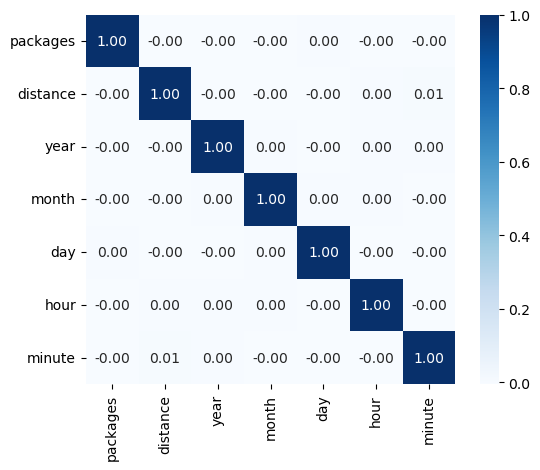

In [33]:
# Create a correlation heatmap.
corr_df = df[num_features]\
            .drop('delivery', axis=1)\
            .corr()

sns.heatmap(corr_df,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 10},
            cmap="Blues")

plt.show()

In [34]:
# Function to create numerical distribution plot.
def distribution_plot(col):
    plt.figure(figsize=(8, 4))
    df[col].plot(kind='hist', bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()

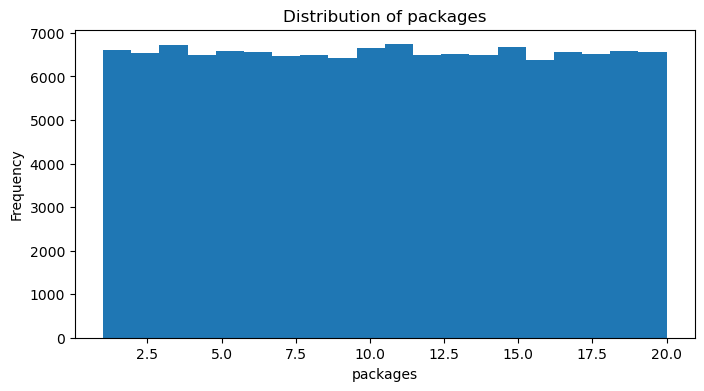

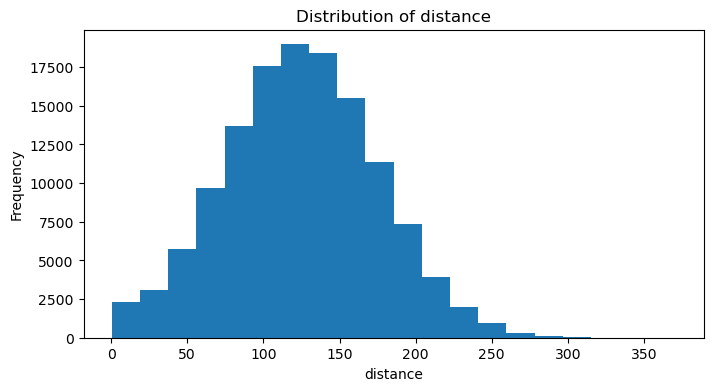

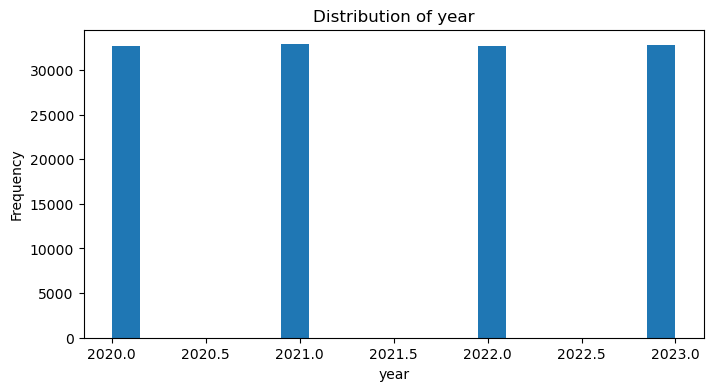

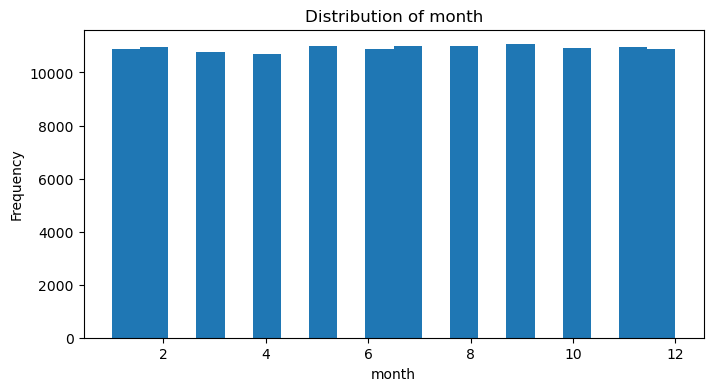

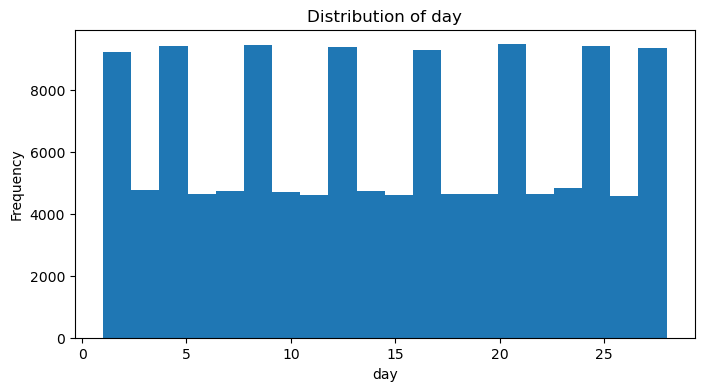

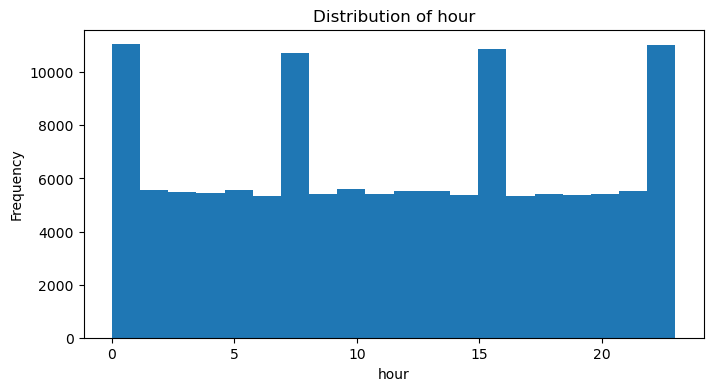

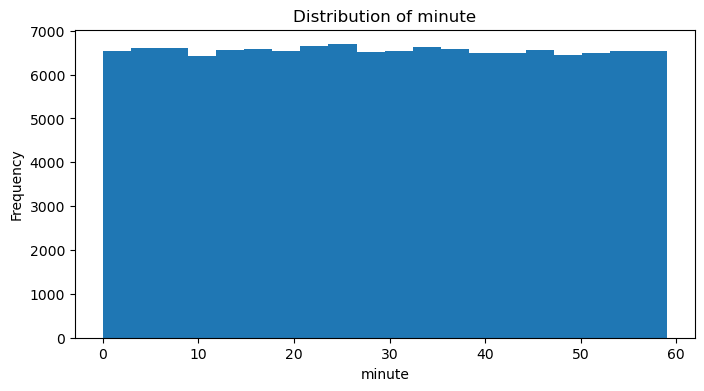

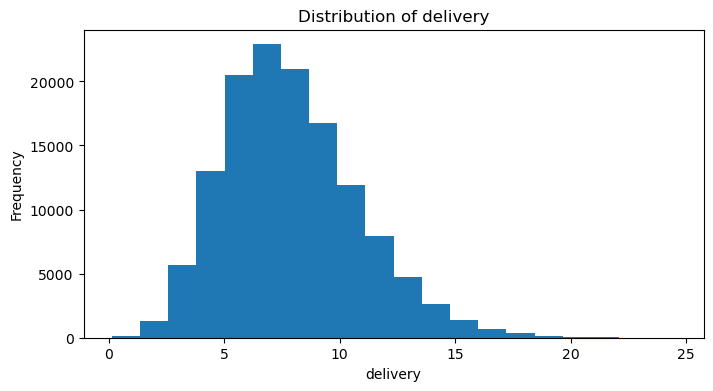

In [35]:
# Show distribution plot for num_features.
for col in num_features:
    distribution_plot(col)

In [36]:
# Function to create categorical count plot.
def count_plot(col):
  plt.figure(figsize=(8, 4))
  df[col].value_counts().plot(kind='bar')
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.show()

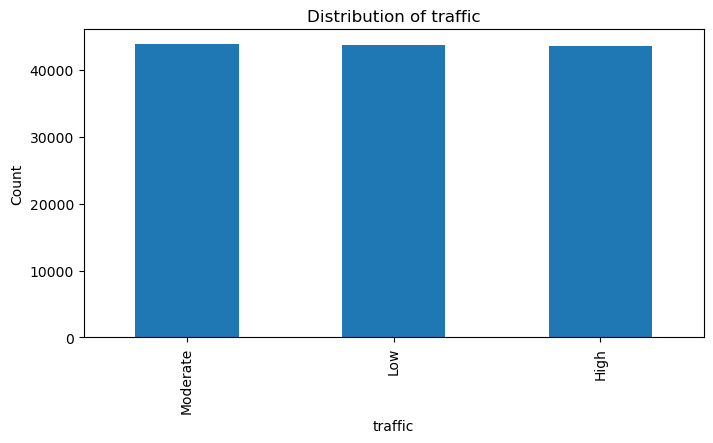

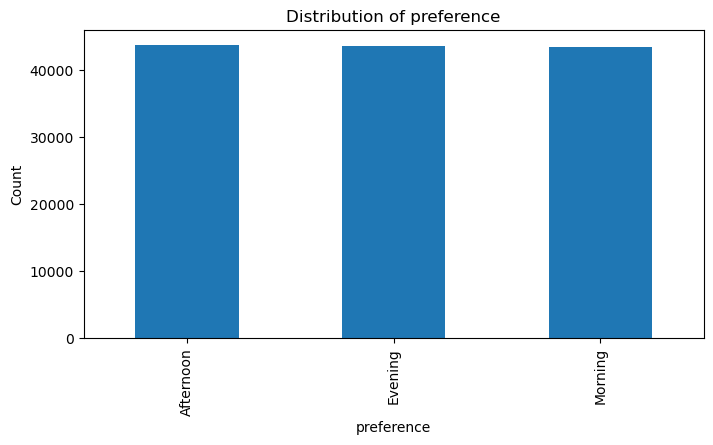

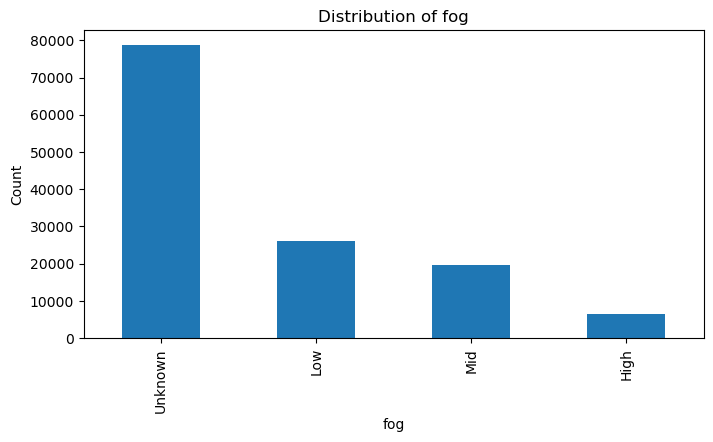

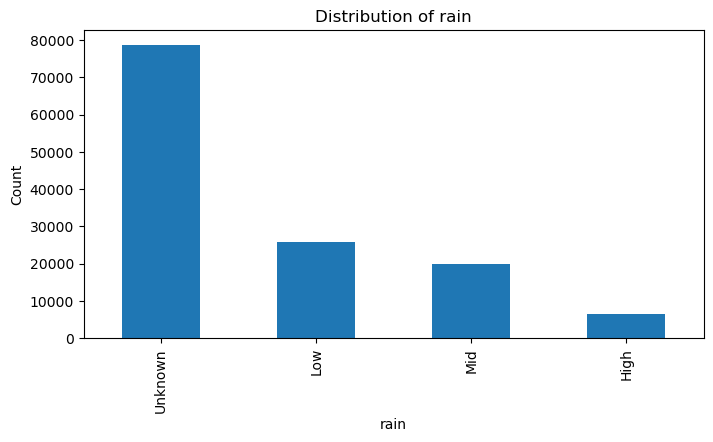

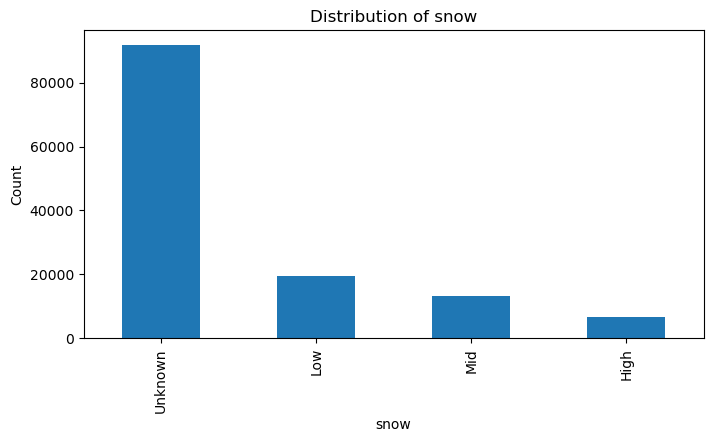

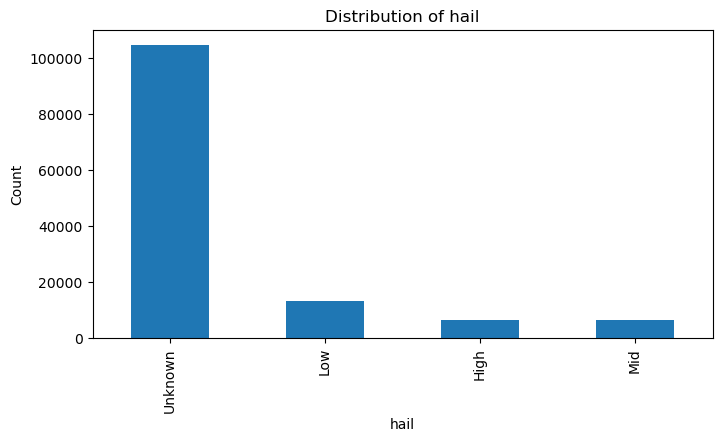

In [37]:
# Show count plot for cat_features.
for col in cat_features:
    count_plot(col)

### Outliers

In [38]:
# Function to create box plot.
def box_plot(col):
    plt.figure(figsize=(6, 3))
    plt.title(f'{col}')
    sns.boxplot(x=df[col])
    plt.plot()

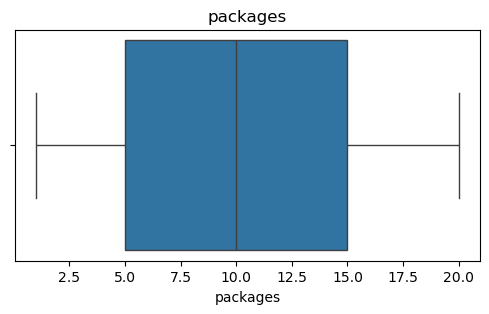

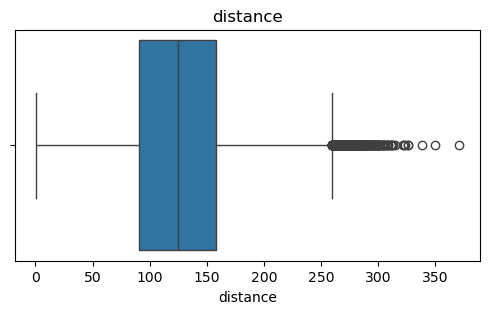

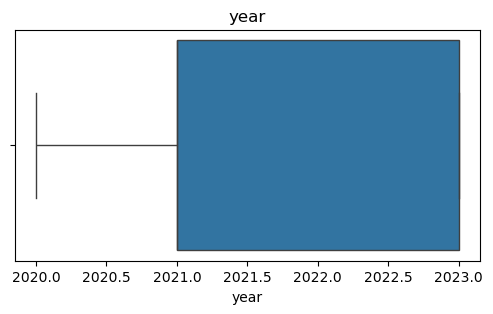

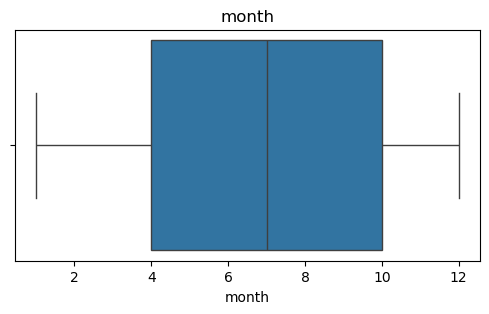

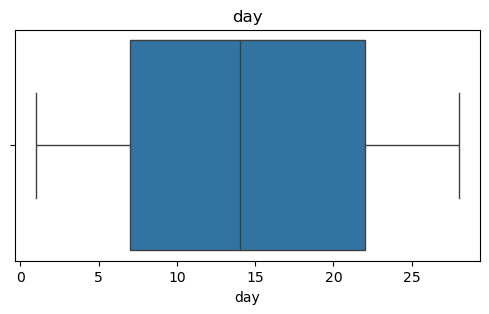

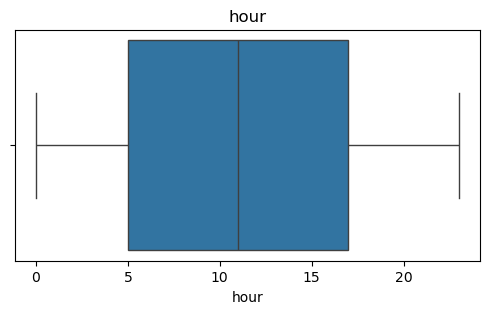

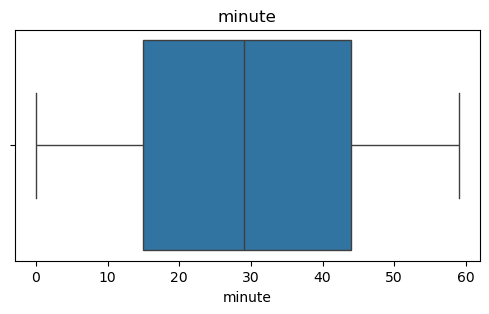

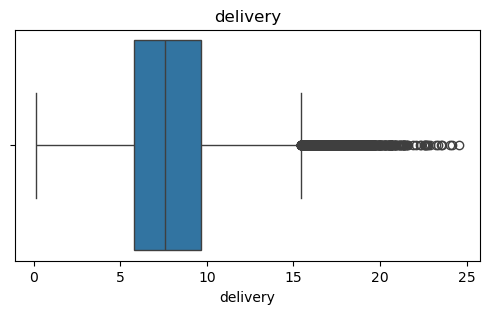

In [39]:
# Show box plot for num_features.
for col in num_features:
    box_plot(col)

There is need to explore the distance and delivery columns further.

In [40]:
# Define the outlier columns.
out_col = ['distance', 'delivery']

In [41]:
# Find the length of df.
df_original_length = df.shape[0]
print(f'df_original_length: {df_original_length}')

df_original_length: 130994


In [42]:
# Calculate IQR and the limits.
Q1, Q3 = df[out_col].quantile(0.25), df[out_col].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

print(f'lower limits:\n{lower}\n')
print(f'upper limits:\n{upper}')

lower limits:
distance   -10.163355
delivery     0.010900
dtype: float64

upper limits:
distance    259.523281
delivery     15.443035
dtype: float64


In [43]:
# Create function to remove outliers.
def out_remove(df):
    for col in out_col:
        out_remove = [False if x < lower[col] or x > upper[col] else True for x in df[col]]
        df = df[out_remove]
    return df

In [44]:
# Remove outliers in df.
df = out_remove(df)

In [45]:
# Find new length of df.
df_remain_length = df.shape[0]
print(f'df_remain_length: {df_remain_length}')

df_remain_length: 128830


In [46]:
# Find percentage of removed data.
removed_data = (df_original_length - df_remain_length) * 100 / df_original_length
print(f'removed_data: {removed_data:.2f}%')

removed_data: 1.65%


### Save The Data To File.

In [47]:
# Save the file as parquet.
df.to_parquet(path='./data/Project_Notes_011_renewable_data.parquet', compression='gzip', index=False)

In [48]:
# load the saved file.
df_esb = pd.read_parquet('./data/Project_Notes_011_renewable_data.parquet')

### Further Feature Engineering

In [49]:
# Subset categorical and numerical columns
num_features = df_esb.select_dtypes(include="number").columns.to_list()
cat_features = df_esb.select_dtypes(exclude="number").columns.to_list()

In [50]:
# Get the unique values in the cat_features columns.
for col in cat_features:
    print(f'Unique values in {col} are: {sorted(list(df_esb[col].unique()))}')

Unique values in traffic are: ['High', 'Low', 'Moderate']
Unique values in preference are: ['Afternoon', 'Evening', 'Morning']
Unique values in fog are: ['High', 'Low', 'Mid', 'Unknown']
Unique values in rain are: ['High', 'Low', 'Mid', 'Unknown']
Unique values in snow are: ['High', 'Low', 'Mid', 'Unknown']
Unique values in hail are: ['High', 'Low', 'Mid', 'Unknown']


In [51]:
# Create masks for the cat_features columns.
mask_traffic = {'Low': 1, 'Moderate': 2, 'High': 3}
mask_preference = {'Morning': 1, 'Afternoon': 2, 'Evening': 3}
mask_others = {'Low': 1, 'Mid': 2, 'High': 3, 'Unknown': 3}

In [52]:
# Create a function to apply the masks.
def mask_unique(df):
    df['traffic'] = df['traffic'].map(mask_traffic)
    df['preference'] = df['preference'].map(mask_preference)
    df['fog'] = df['fog'].map(mask_others)
    df['rain'] = df['rain'].map(mask_others)
    df['snow'] = df['snow'].map(mask_others)
    df['hail'] = df['hail'].map(mask_others)
    return df

In [53]:
# Apply the mask function.
mask_unique(df_esb)

,traffic,packages,preference,distance,fog,rain,snow,hail,year,month,day,hour,minute,delivery
0,1,7,3,167.884751,3,3,1,3,2020,9,3,12,41,9.294688
1,1,10,1,154.154474,1,3,2,3,2022,12,22,20,14,9.303765
2,3,2,2,196.084835,3,2,3,3,2021,6,5,11,20,8.734668
3,3,15,1,94.010339,3,3,3,3,2023,5,2,5,50,7.806979
4,2,17,3,202.254271,2,3,3,3,2020,7,7,2,34,12.770403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128825,3,14,2,129.664099,2,3,2,3,2020,1,11,23,19,10.144627
128826,2,7,2,180.837540,3,1,3,3,2020,6,23,10,44,6.494870
128827,1,6,3,147.811287,1,1,3,3,2020,6,4,23,13,7.818925
128828,1,12,3,89.197186,3,3,3,3,2022,12,1,1,5,4.545268


### Modeling And Selection  
**Train tree based/ensemble models**

In [54]:
# Prepare X and Y variables
X = df_esb.drop(columns=['delivery'], axis=1)
y = df_esb['delivery']

In [55]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models.
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Training and evaluation loop.
for model_name, model in models.items():
    
    # Train the model.
    model.fit(X_train, y_train)

    # Make predictions.
    y_pred = model.predict(X_test)

    # Calculate RMSE, MAE, and MAPE.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE in percentage

    # Print the results.
    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("=" * 40)

Model: Decision Tree
RMSE: 2.55
MAE: 2.02
MAPE: 28.00%
Model: Random Forest
RMSE: 1.79
MAE: 1.45
MAPE: 20.52%
Model: Gradient Boosting
RMSE: 1.72
MAE: 1.40
MAPE: 19.74%


**Train Neigbours models**

In [56]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN regressor models with different values of k.
k_values = [1, 3, 5, 7, 9]  # You can adjust these values
models = {f"KNN (k={k})": KNeighborsRegressor(n_neighbors=k) for k in k_values}

# Training and evaluation loop.
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions.
    y_pred = model.predict(X_test)

    # Calculate RMSE, MAE, and MAPE.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE in percentage

    # Print the results.
    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("=" * 40)

Model: KNN (k=1)
RMSE: 2.84
MAE: 2.25
MAPE: 31.86%
Model: KNN (k=3)
RMSE: 2.32
MAE: 1.84
MAPE: 26.38%
Model: KNN (k=5)
RMSE: 2.21
MAE: 1.76
MAPE: 25.34%
Model: KNN (k=7)
RMSE: 2.16
MAE: 1.73
MAPE: 24.92%
Model: KNN (k=9)
RMSE: 2.13
MAE: 1.71
MAPE: 24.66%


**Train Linear models**

In [57]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear models.
linear_regressor = LinearRegression()
lasso_regressor = Lasso(alpha=1.0)
ridge_regressor = Ridge(alpha=1.0)
elasticnet_regressor = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Create a dictionary of models.
models = {
    "Linear Regression": linear_regressor,
    "Lasso Regression": lasso_regressor,
    "Ridge Regression": ridge_regressor,
    "Elastic Net": elasticnet_regressor
}

# Training and evaluation loop for each model.
for model_name, model in models.items():
    
    # Train the model.
    model.fit(X_train, y_train)

    # Make predictions.
    y_pred = model.predict(X_test)

    # Calculate RMSE, MAE, and MAPE.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE in percentage

    # Print the results.
    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("=" * 40)

Model: Linear Regression
RMSE: 1.86
MAE: 1.50
MAPE: 21.17%
Model: Lasso Regression
RMSE: 2.10
MAE: 1.71
MAPE: 25.28%
Model: Ridge Regression
RMSE: 1.86
MAE: 1.50
MAPE: 21.17%
Model: Elastic Net
RMSE: 2.06
MAE: 1.67
MAPE: 24.57%


The top performing models are : Random Forest, Gradient Boosting and KNN

### Hyperparameter Tuning Using Grid Search

**Imporoving Random Forest Using Grid serach**

In [58]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor.
rf_regressor = RandomForestRegressor(random_state=42)

# Define the hyperparameters and their possible values for the grid search.
param_grid = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4],   # Minimum number of samples required at each leaf node
}

# Create the grid search.
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Perform the grid search on the training data.
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search.
best_rf_params = grid_search.best_params_

# Get the best model from the grid search.
best_rf_model = grid_search.best_estimator_

# Make predictions.
y_pred = best_rf_model.predict(X_test)

# Calculate RMSE and MAE.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics.
print("Best Hyperparameters:")
print(best_rf_params)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters:
{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RMSE: 1.78
MAE: 1.44


### Impoving Gradient Boosting Regressor Using Grid serach

In [59]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Gradient Boosting Regressor.
gb_regressor = GradientBoostingRegressor(random_state=42)

# Define the hyperparameters and their possible values for the grid search.
param_grid = {
    'n_estimators': [100],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 4, 5],  # Maximum depth of individual trees
}

# Create the grid search.
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Perform the grid search on the training data.
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search.
best_gb_params = grid_search.best_params_

# Get the best model from the grid search.
best_gb_model = grid_search.best_estimator_

# Make predictions.
y_pred = best_gb_model.predict(X_test)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics.
print("Best Hyperparameters:")
print(best_gb_params)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Hyperparameters:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
RMSE: 1.72
MAE: 1.39


### Improving K Nearest Neighbor Regressor Using Grid Serach

In [60]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN Regressor.
knn_regressor = KNeighborsRegressor()

# Define the hyperparameters and their possible values for the grid search.
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting strategy for neighbors
}

# Create the grid search.
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Perform the grid search on the training data.
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search.
best_knn_params = grid_search.best_params_

# Get the best model from the grid search.
best_knn_model = grid_search.best_estimator_

# Make predictions.
y_pred = best_knn_model.predict(X_test)

# Calculate RMSE and MAE.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics.
print("Best Hyperparameters:")
print(best_knn_params)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters:
{'n_neighbors': 11, 'weights': 'distance'}
RMSE: 2.11
MAE: 1.70


In [61]:
# Extract the best parameters of RandomForestRegressor.
max_depth = best_rf_params['max_depth']
min_samples_leaf = best_rf_params['min_samples_leaf']
min_samples_split = best_rf_params['min_samples_split']
n_estimators = best_rf_params['n_estimators']

In [62]:
# Get final RandomForestRegressor model.
final_rf = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth, 
    min_samples_leaf= min_samples_leaf, 
    min_samples_split=min_samples_split
)

final_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10)

In [63]:
# Extract the best parameters of GradientBoostingRegressor.
learning_rate = best_gb_params['learning_rate']
max_depth = best_gb_params['max_depth']
n_estimators = best_gb_params['n_estimators']

In [64]:
# Get final GradientBoostingRegressor model.
final_gb = GradientBoostingRegressor(
    learning_rate=learning_rate, 
    max_depth=max_depth, 
    n_estimators=n_estimators
)

final_gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2)

In [65]:
# Extract the best parameters of KNeighborsRegressor.
n_neighbors = best_knn_params['n_neighbors']
weights = best_knn_params['weights']

In [66]:
# Get final KNeighborsRegressor model.
final_knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
final_knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=11, weights='distance')

### Ensembling Models: Stacking Vs Averaging  
**Stacking**

In [67]:
# Initialize the base models.
final_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=4, min_samples_split=10)
final_gb = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, n_estimators=100)
final_knn = KNeighborsRegressor(n_neighbors=11, weights="distance")

# Create a list of base models.
base_models = [('KNN', final_knn), ('GBR', final_gb), ('RFR', final_rf)]

# Initialize the meta-model (Linear Regression in this case).
meta_model = LinearRegression()

# Create the stacking ensemble
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stacking ensemble to the data.
stacking_regressor.fit(X_train, y_train)

# Make predictions.
y_pred = stacking_regressor.predict(X_test)

# Evaluate the ensemble.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Stacking Ensemble RMSE: {rmse:.2f}")
print(f"Stacking Ensemble MAE: {mae:.2f}")

Stacking Ensemble RMSE: 1.72
Stacking Ensemble MAE: 1.39


**Averaging**

In [68]:
# Initialize the base models.
final_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf= 4, min_samples_split=10)
final_gb = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, n_estimators=100)
final_knn = KNeighborsRegressor(n_neighbors=11, weights="distance")

# Create a list of base models.
base_models = [('KNN', final_knn), ('GBR', final_gb), ('RFR', final_rf)]

# Initialize the ensemble (VotingRegressor with averaging).
ensemble_regressor = VotingRegressor(estimators=base_models)

# Fit the ensemble to the data.
ensemble_regressor.fit(X_train, y_train)

# Make predictions.
y_pred = ensemble_regressor.predict(X_test)

# Evaluate the ensemble.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Averaging Ensemble RMSE: {rmse:.2f}")
print(f"Averaging Ensemble MAE: {mae:.2f}")

Averaging Ensemble RMSE: 1.78
Averaging Ensemble MAE: 1.45


### Use The Model For Some Predictions

In [69]:
# Save the stacking_regressor model.
pickle.dump(stacking_regressor, 
            gzip.open('./data/Project_Notes_011_renewable_esb.pkl', 'wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
# load the stacking_regressor model.
loaded_model = pickle.load(gzip.open('./data/Project_Notes_011_renewable_esb.pkl', 'rb'))

In [71]:
# Create function to predict the raw data
def predict_data(raw_data):
    data_frame = pd.DataFrame(raw_data, index=[0])
    data_frame = mask_unique(data_frame)
    data_predict = loaded_model.predict(data_frame).round(6)
    return data_predict[0]

In [72]:
# Get the sample data to use.
sample_data = df.loc[2120]
sample_data

traffic              Low
packages               2
preference       Morning
distance      133.539599
fog              Unknown
rain                 Low
snow             Unknown
hail             Unknown
year                2020
month                  3
day                    7
hour                  10
minute                 5
delivery        4.738282
Name: 2120, dtype: object

In [73]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Low',
 'packages': 2,
 'preference': 'Morning',
 'distance': 133.53959872358544,
 'fog': 'Unknown',
 'rain': 'Low',
 'snow': 'Unknown',
 'hail': 'Unknown',
 'year': 2020,
 'month': 3,
 'day': 7,
 'hour': 10,
 'minute': 5}

In [74]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

5.332634

In [75]:
# Get the sample data to use.
sample_data = df.loc[8532]
sample_data

traffic         Moderate
packages               3
preference       Morning
distance      174.223568
fog              Unknown
rain             Unknown
snow             Unknown
hail             Unknown
year                2023
month                  9
day                    9
hour                   6
minute                 6
delivery        7.041586
Name: 8532, dtype: object

In [76]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Moderate',
 'packages': 3,
 'preference': 'Morning',
 'distance': 174.22356768163223,
 'fog': 'Unknown',
 'rain': 'Unknown',
 'snow': 'Unknown',
 'hail': 'Unknown',
 'year': 2023,
 'month': 9,
 'day': 9,
 'hour': 6,
 'minute': 6}

In [77]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

7.491504

In [78]:
# Get the sample data to use.
sample_data = df.loc[11065]
sample_data

traffic              Low
packages               5
preference       Evening
distance      155.316108
fog                  Mid
rain             Unknown
snow             Unknown
hail             Unknown
year                2022
month                  3
day                    2
hour                  11
minute                43
delivery        6.745776
Name: 11065, dtype: object

In [79]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Low',
 'packages': 5,
 'preference': 'Evening',
 'distance': 155.3161075954646,
 'fog': 'Mid',
 'rain': 'Unknown',
 'snow': 'Unknown',
 'hail': 'Unknown',
 'year': 2022,
 'month': 3,
 'day': 2,
 'hour': 11,
 'minute': 43}

In [80]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

6.703557

In [81]:
# Get the sample data to use.
sample_data = df.loc[759]
sample_data

traffic            High
packages             11
preference      Morning
distance      87.086422
fog                 Mid
rain                Mid
snow                Mid
hail                Low
year               2022
month                 4
day                  21
hour                  3
minute               48
delivery      10.840608
Name: 759, dtype: object

In [82]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'High',
 'packages': 11,
 'preference': 'Morning',
 'distance': 87.08642239422535,
 'fog': 'Mid',
 'rain': 'Mid',
 'snow': 'Mid',
 'hail': 'Low',
 'year': 2022,
 'month': 4,
 'day': 21,
 'hour': 3,
 'minute': 48}

In [83]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

9.73265

In [84]:
# Get the sample data to use.
sample_data = df.loc[129281]
sample_data

traffic              Low
packages               4
preference     Afternoon
distance      145.937363
fog                  Low
rain                 Mid
snow                 Low
hail                 Low
year                2023
month                  8
day                   25
hour                  17
minute                36
delivery         9.77849
Name: 129281, dtype: object

In [85]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Low',
 'packages': 4,
 'preference': 'Afternoon',
 'distance': 145.93736296224964,
 'fog': 'Low',
 'rain': 'Mid',
 'snow': 'Low',
 'hail': 'Low',
 'year': 2023,
 'month': 8,
 'day': 25,
 'hour': 17,
 'minute': 36}

In [86]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

8.734935

### Use A XGB Regressor To To Create The Model

In [87]:
# load the saved file.
df_xgb = pd.read_parquet('./data/Project_Notes_011_renewable_data.parquet')

# Prepare X and Y variables
X = df_xgb.drop(columns=['delivery'], axis=1)
y = df_xgb['delivery']

# Subset categorical and numerical columns
num_features = X.select_dtypes(include="number").columns.to_list()
cat_features = X.select_dtypes(exclude="number").columns.to_list()

preprocessor = make_column_transformer(
                                        (StandardScaler(), num_features),
                                        (OrdinalEncoder(), cat_features)
                                       )

# Split dataset to train, test and validation sets.
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

# Train a xgb regressor model.
xgb = make_pipeline(preprocessor, XGBRegressor())
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['packages', 'distance',
                                                   'year', 'month', 'day',
                                                   'hour', 'minute']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['traffic', 'preference',
                                                   'fog', 'rain', 'snow',
                                                   'hail'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [88]:
# Compute RMSE and MAE.
pred_val = xgb.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mae = mean_absolute_error(y_val, pred_val)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 1.58
MAE: 1.31


In [89]:
# Use RandomizedSearchCV to find the best hyperparameters.
xgb = make_pipeline(preprocessor, XGBRegressor())

params = {
   'xgbregressor__eta': [0.1, 0.2, 0.3, 0.5, 0.6],
   'xgbregressor__max_depth': [3, 4, 5, 7, 10],
   'xgbregressor__min_child_weight': [20, 30, 40, 50, 60]
}

gscv = RandomizedSearchCV(
   estimator=xgb,
   param_distributions=params,
   n_iter=50,
   cv=5,
   n_jobs=-1
)

gscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['packages',
                                                                                'distance',
                                                                                'year',
                                                                                'month',
                                                                                'day',
                                                                                'hour',
                                                                                'minute']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(),
                                                                               ['traffic',
                                                                                'preference',
                                                                                'fog',
                                                                                'rain',
                                                                                'snow',
                                                                                'hail'])])),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           c...
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'xgbregressor__eta': [0.1, 0.2, 0.3,
                                                              0.5, 0.6],
                                        'xgbregressor__max_depth': [3, 4, 5, 7,
                                                                    10],
                                        'xgbregressor__min_child_weight': [20,
                                                                           30,
                                                                           40,
                                                                           50,
                                                                           60]})

In [90]:
# Get model best parameters.
best_params = gscv.best_params_
print(f'best_params:\n{best_params}')

best_params:
{'xgbregressor__min_child_weight': 20, 'xgbregressor__max_depth': 3, 'xgbregressor__eta': 0.2}


In [91]:
# Use GridSearchCV to find the best hyperparameters.

xgb = make_pipeline(preprocessor, XGBRegressor())

params = {
   'xgbregressor__eta': [0.1, 0.2, 0.3],
   'xgbregressor__max_depth': [2, 3, 4],
   'xgbregressor__min_child_weight': [20, 30, 40]
}

gscv = GridSearchCV(
   estimator=xgb,
   param_grid=params,
   cv=5,
   n_jobs=-1
)

gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['packages',
                                                                          'distance',
                                                                          'year',
                                                                          'month',
                                                                          'day',
                                                                          'hour',
                                                                          'minute']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['traffic',
                                                                          'preference',
                                                                          'fog',
                                                                          'rain',
                                                                          'snow',
                                                                          'hail'])])),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbac...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__eta': [0.1, 0.2, 0.3],
                         'xgbregressor__max_depth': [2, 3, 4],
                         'xgbregressor__min_child_weight': [20, 30, 40]})

In [92]:
# Get the best parameters.
best_params = gscv.best_params_
print(f'best_params:\n{best_params}')

best_params:
{'xgbregressor__eta': 0.2, 'xgbregressor__max_depth': 3, 'xgbregressor__min_child_weight': 30}


In [93]:
# Get the best estimator.
xgb = gscv.best_estimator_

In [94]:
# Compute RMSE and MAE.
pred_val = xgb.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mae = mean_absolute_error(y_val, pred_val)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 1.55
MAE: 1.29


In [95]:
# Extract the parameters.
eta = best_params['xgbregressor__eta']
max_depth = best_params['xgbregressor__max_depth']
min_child_weight = best_params['xgbregressor__min_child_weight']

print(f'eta: {eta}')
print(f'max_depth: {max_depth}')
print(f'min_child_weight: {min_child_weight}')

eta: 0.2
max_depth: 3
min_child_weight: 30


In [96]:
# Train with full_train.
xgb_final = make_pipeline(preprocessor, 
                          XGBRegressor(eta=eta, 
                                       max_depth=max_depth, 
                                       min_child_weight=min_child_weight))

xgb_final.fit(X_full_train, y_full_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['packages', 'distance',
                                                   'year', 'month', 'day',
                                                   'hour', 'minute']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['traffic', 'preference',
                                                   'fog', 'rain', 'snow',
                                                   'hail'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=No...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=30,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [97]:
# Compute RMSE and MAE.
pred_test = xgb_final.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 1.55
MAE: 1.30


In [98]:
# Save the xgb_regressor model.
pickle.dump(xgb_final, 
            gzip.open('./data/Project_Notes_011_renewable_xgb.pkl', 'wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

In [99]:
# load the xgb_regressor model.
loaded_model = pickle.load(gzip.open('./data/Project_Notes_011_renewable_xgb.pkl', 'rb'))

### Use The XGB Model For Some Predictions

In [100]:
# Create function to predict the raw data
def predict_data(raw_data):
    data_frame = pd.DataFrame(raw_data, index=[0])
    data_predict = loaded_model.predict(data_frame)
    return data_predict[0]

In [101]:
# Get the sample data to use.
sample_data = df.loc[2120]
sample_data

traffic              Low
packages               2
preference       Morning
distance      133.539599
fog              Unknown
rain                 Low
snow             Unknown
hail             Unknown
year                2020
month                  3
day                    7
hour                  10
minute                 5
delivery        4.738282
Name: 2120, dtype: object

In [102]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Low',
 'packages': 2,
 'preference': 'Morning',
 'distance': 133.53959872358544,
 'fog': 'Unknown',
 'rain': 'Low',
 'snow': 'Unknown',
 'hail': 'Unknown',
 'year': 2020,
 'month': 3,
 'day': 7,
 'hour': 10,
 'minute': 5}

In [103]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

4.7583795

In [104]:
# Get the sample data to use.
sample_data = df.loc[8532]
sample_data

traffic         Moderate
packages               3
preference       Morning
distance      174.223568
fog              Unknown
rain             Unknown
snow             Unknown
hail             Unknown
year                2023
month                  9
day                    9
hour                   6
minute                 6
delivery        7.041586
Name: 8532, dtype: object

In [105]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Moderate',
 'packages': 3,
 'preference': 'Morning',
 'distance': 174.22356768163223,
 'fog': 'Unknown',
 'rain': 'Unknown',
 'snow': 'Unknown',
 'hail': 'Unknown',
 'year': 2023,
 'month': 9,
 'day': 9,
 'hour': 6,
 'minute': 6}

In [106]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

7.0581007

In [107]:
# Get the sample data to use.
sample_data = df.loc[11065]
sample_data

traffic              Low
packages               5
preference       Evening
distance      155.316108
fog                  Mid
rain             Unknown
snow             Unknown
hail             Unknown
year                2022
month                  3
day                    2
hour                  11
minute                43
delivery        6.745776
Name: 11065, dtype: object

In [108]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Low',
 'packages': 5,
 'preference': 'Evening',
 'distance': 155.3161075954646,
 'fog': 'Mid',
 'rain': 'Unknown',
 'snow': 'Unknown',
 'hail': 'Unknown',
 'year': 2022,
 'month': 3,
 'day': 2,
 'hour': 11,
 'minute': 43}

In [109]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

6.302852

In [110]:
# Get the sample data to use.
sample_data = df.loc[759]
sample_data

traffic            High
packages             11
preference      Morning
distance      87.086422
fog                 Mid
rain                Mid
snow                Mid
hail                Low
year               2022
month                 4
day                  21
hour                  3
minute               48
delivery      10.840608
Name: 759, dtype: object

In [111]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'High',
 'packages': 11,
 'preference': 'Morning',
 'distance': 87.08642239422535,
 'fog': 'Mid',
 'rain': 'Mid',
 'snow': 'Mid',
 'hail': 'Low',
 'year': 2022,
 'month': 4,
 'day': 21,
 'hour': 3,
 'minute': 48}

In [112]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

9.57716

In [113]:
# Get the sample data to use.
sample_data = df.loc[129281]
sample_data

traffic              Low
packages               4
preference     Afternoon
distance      145.937363
fog                  Low
rain                 Mid
snow                 Low
hail                 Low
year                2023
month                  8
day                   25
hour                  17
minute                36
delivery         9.77849
Name: 129281, dtype: object

In [114]:
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 'Low',
 'packages': 4,
 'preference': 'Afternoon',
 'distance': 145.93736296224964,
 'fog': 'Low',
 'rain': 'Mid',
 'snow': 'Low',
 'hail': 'Low',
 'year': 2023,
 'month': 8,
 'day': 25,
 'hour': 17,
 'minute': 36}

In [115]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

8.530756